In [307]:
from __future__ import print_function
import sys
import cv2
import matplotlib.pyplot as plt
import time
import chess
import numpy as np

In [308]:
url = "http://100.66.103.27:8080/video"

In [309]:
# coords = []
# def mouse_drawing(event, x, y, flags, params):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print("Left click")
#         coords.append((x, y))

# cap = cv2.VideoCapture(url)

# cv2.namedWindow('image')
# cv2.setMouseCallback('image',mouse_drawing)

# while len(coords) < 4:
#     _, frame = cap.read()
    
#     cv2.imshow('image', frame)
    
    
#     k = cv2.waitKey(20) & 0xFF
#     if k == 27:
#         break
# cv2.destroyAllWindows()

In [310]:
cap = cv2.VideoCapture(url)


ret = False

while not ret:
    
    _, first_frame = cap.read()
    ret, res = cv2.findChessboardCorners(first_frame, (7, 7))
    
res = res[:,0, :]

In [293]:
min_x, max_x = res[:, 0].min(), res[:, 0].max()
min_y, max_y = res[:, 1].min(), res[:, 1].max()

dx = (max_x - min_x) / 6
dy = (max_y - min_y) / 6


board_corner = np.array([
                 [min_x - dx, max_y + dy],
                 [min_x - dx, min_y - dy],
                 [max_x + dx, max_y + dy],
                 [max_x + dx, min_y - dy],
                        ])

res = np.vstack((res, board_corner))

In [294]:
first_frame_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

In [295]:
cap.release()

In [296]:
first_frame_copy = first_frame.copy()
for x, y in res:
    cv2.circle(first_frame_copy, (int(x), int(y)), 10, (0, 255, 0), -1)

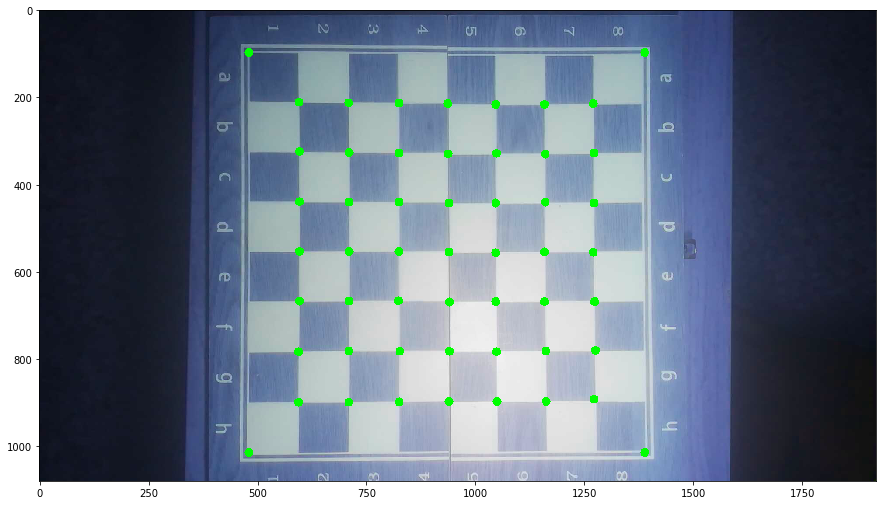

In [297]:
plt.figure(figsize=(15, 15))
plt.imshow(first_frame_copy)

In [298]:
width = 400

pst1 = np.float32(board_corner)
pst2 = np.float32([[0,0],[width,0],[0,width],[width,width]])

M = cv2.getPerspectiveTransform(pst1,pst2)
M

array([[ 4.09097503e-17, -4.36081129e-01,  4.42332654e+02],
       [ 4.40598500e-01,  5.30089241e-18, -2.12204301e+02],
       [ 1.56532026e-19,  2.32390705e-19,  1.00000000e+00]])

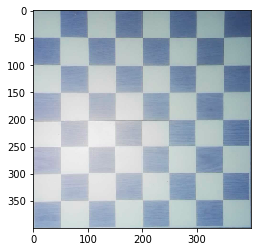

In [299]:
cap = cv2.VideoCapture(url)
_, t = cap.read()
plt.imshow(cv2.warpPerspective(t, M, (width, width)))

In [300]:
def getGridSum(img_gray):
    img_canny = cv2.Canny(img_gray, 20, 100)

    vert_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_canny.shape[1] / 40)))
    horr_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_canny.shape[1] / 40), 1))

    vertical = cv2.erode(img_canny, vert_rect)
    vertical = cv2.dilate(vertical, vert_rect)

    horizontal = cv2.erode(img_canny, horr_rect)
    horizontal = cv2.dilate(horizontal, horr_rect)


    img_grid = horizontal + vertical
    img_grid_sum = img_grid.sum()
    
    return int(img_grid_sum), img_grid

In [301]:
empty = first_frame.copy()
empty = cv2.warpPerspective(empty, M, (width, width))
empty_gray = cv2.cvtColor(empty, cv2.COLOR_BGR2GRAY)

chess_grid_sum, chess_grid = getGridSum(empty_gray)

In [302]:
def getFrameDiff(frame1, frame2):
    diff = cv2.absdiff(frame1, frame2)
    diff = cv2.threshold(diff, 10, 150, cv2.THRESH_BINARY)[1]
    
    kernel = np.ones((5, 5,))
    diff = cv2.erode(diff, kernel)
    diff = cv2.dilate(diff, kernel)
    
    return diff

In [303]:
def handOn(frame_cur, frame_last, thr = 0.1):
    diff = getFrameDiff(frame_cur, frame_last)
    size = diff.shape[0]
    
    return (diff != 0).sum() / (size*size) >  thr

In [304]:
def getMove(frame_cur, frame_last, board, thr = 0.1):
    diff = getFrameDiff(frame_cur, frame_last)
    
    step = diff.shape[0] // 8
    
    change_square = []
    for i in range(8):
        for j in range(8):
            sub_diff = diff[step*i:step*(i+1),step*j:step*(j+1)]
            
            if (sub_diff != 0).sum()/(step*step) > thr:
                change_square.append([i, j])
                
    moves = []
    for j, i in change_square:
        for l, k in change_square:
            moves.append(chess.Move(i + j*8, k + l*8))
            
    res_move = None
    for move in moves:
        for beaut_move in board.legal_moves:
#         if move in board.legal_moves:
            if beaut_move == move:
                res_move = beaut_move
                
                break
        if res_move is not None:
            break
    
    
    return res_move

d2d4


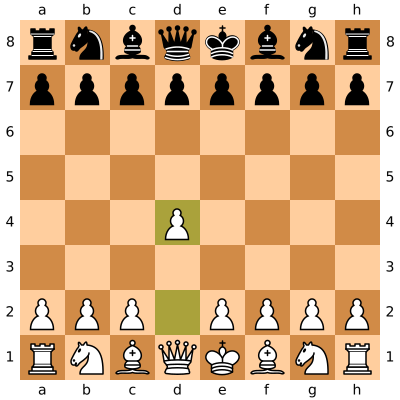

e7e5


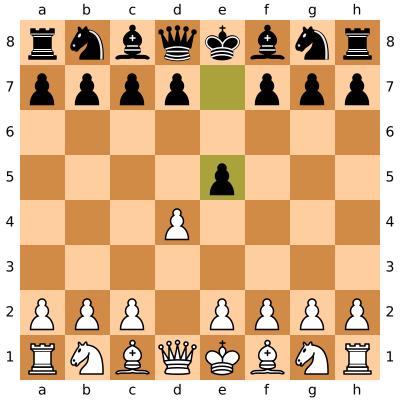

d4e5


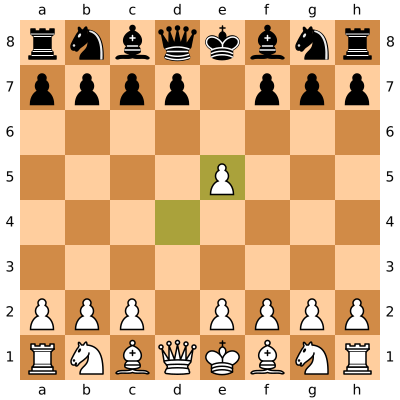

In [306]:
cap = cv2.VideoCapture(url)

_, frame_last = cap.read()
frame_last = cv2.warpPerspective(frame_last, M, (width, width))
frame_last = cv2.cvtColor(frame_last, cv2.COLOR_BGR2GRAY)

board = chess.Board()


hand_on_last = False

# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:

        frame = cv2.warpPerspective(frame, M, (width, width))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         frame = cv2.Canny(frame,50,100)
    #     frame = cv2.absdiff(frame, empty_gray)

        
#         
        hand_on_cur = handOn(frame, frame_last)
        hand_on_change = hand_on_cur ^ hand_on_last

        if hand_on_change and not hand_on_cur:
            time.sleep(2)
            _, frame = cap.read()
            frame = cv2.warpPerspective(frame, M, (width, width))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            

            cur_move = getMove(frame_last, frame, board)
            print(cur_move)
            board.push(cur_move)
            display(board)
            frame_last = frame.copy()

        hand_on_last = hand_on_cur
        
        msg_text = "hand on" if hand_on_cur else "hand off"
        # Display the resulting frame
        frame = cv2.putText(frame, msg_text, (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        cv2.imshow('Frame',frame)


        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        
        cap = cv2.VideoCapture(url)
    # Break the loop
    else: 
        break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [311]:
import threading

In [312]:
t = threading.Thread()

In [313]:
t.join(0.1)

AttributeError: 'Thread' object has no attribute 'jpg'

In [165]:
import chess.svg
import cairosvg

In [180]:
t_ = chess.svg.board(board)
t_ = cairosvg.svg2png(str(t_))

In [181]:
from PIL import Image

In [233]:
from io import BytesIO
tempBuff = BytesIO()
tempBuff.write(t_)
tempBuff.seek(0)

im = Image.open(tempBuff)

In [283]:
t = background.convert('RGB')

In [285]:
t.tobytes()

b'\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x

In [278]:
pixels = list(t.getdata())
width, height = t.size
pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]

In [273]:
im_np = np.array(pixels)

In [274]:
im_np.shape

(400, 400, 3)

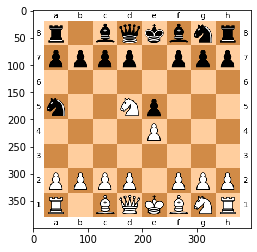

In [276]:
plt.imshow(pixels)

In [282]:
t_

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01\x90\x08\x06\x00\x00\x00\x80\xbf6\xcc\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddwx\x14U\xdb\xc0\xe1\xdfl:\xa1\x85\xde\x9b\x94\xd0\x8b4A\x04i*HW\x14\xbb\x80(*\xa2\x08\x9f\xefky\x05;U\xa4)\xa0\x82\xa0R\x84 UAz@\xa9\x01B\t\x04\x085@HH\xef\xd9\x9d\xf9\xfeX\x12\x12R\xb6d6\xbb\xc1\xe7\xbe\xae\\\x90\xcd\xcc\xec\xc3\xe1\xe4<{\xca\x9c\x01!\x84\x10B\x08!\x84\x10B\x08!\x84\x10B\x08!\n\xb6\x15\xf8\xca\xd9A\xfc\x8b\xfd\x0c|\xef\xec \xeeA\x06\xcc\xe5\x1a\rh@[\xe7\x86sO*\x96m\x87\xbb\xb3\x03\x10B\xb8\xbc\xfe\xc0\x10\xa03p\rHpn8\xc2UH\x02\x11BXR\x1f\x08\x03N9;\x10\xe1Z\x0c\xce\x0e\xc0\x82\xc1\xc0?@\x1c\x10\x05\xac\x03\xea:5"\xcb<\x81y\x98c\xbe\x05L\xc6\xf5\xcb\x19@\x01\xde\x01B\x814 \x1c\x98\xe2\xd4\x88\n\xe6\r,\x04\xe2\x81H\xe0s\xcc\xff\x06W\xa6\x00\xe3\x81s@\np\x12\x18\xee\xd4\x88,[\x05L\x05\xda`\x1e\xbe:\xe7\xdcp\xacR\x02\xf8\x11sO)\xb3n\xfc\x82\xeb\x0fo\xbaan/n\x017\x80/p\xfd:\xed\xd2\x9

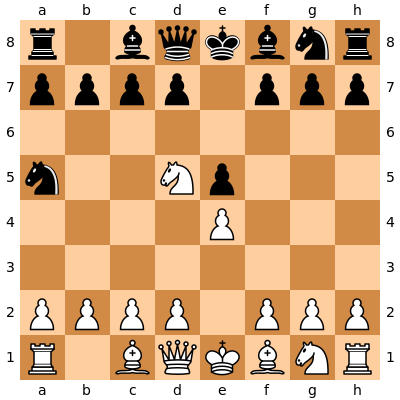

In [249]:
# image = image.convert("RGBA")
background = Image.new('RGBA', im.size, (255, 255, 255))
background.paste(im, im)
im

In [97]:
diff_t = cv2.threshold(diff, 10, 150, cv2.THRESH_BINARY)[1]


kernel = np.ones((5, 5))
diff_t = cv2.erode(diff_t, kernel)
diff_t = cv2.dilate(diff_t, kernel)

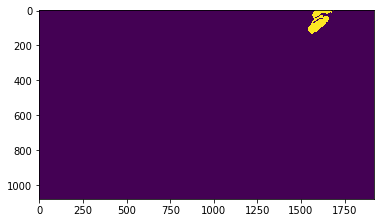

In [98]:
plt.imshow(diff_t)

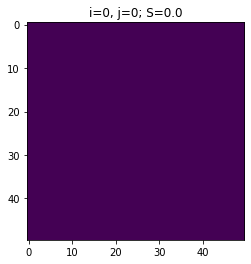

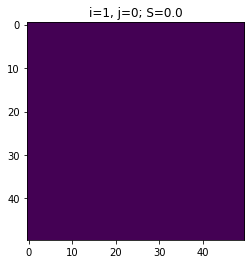

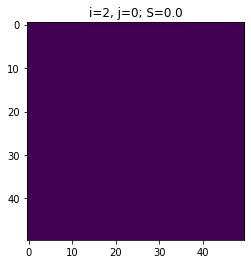

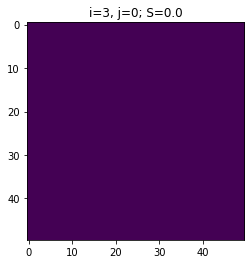

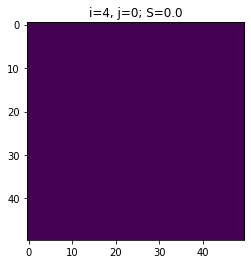

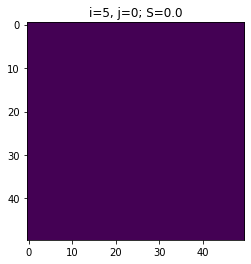

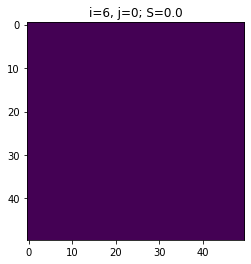

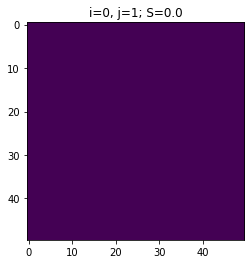

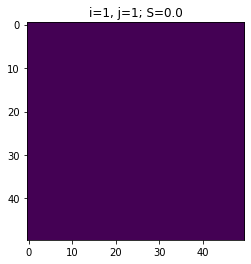

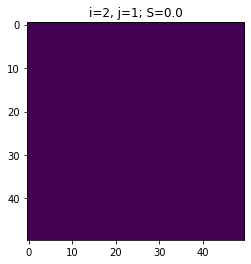

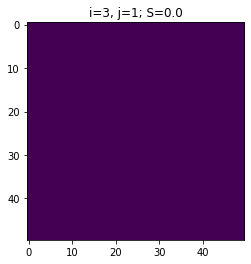

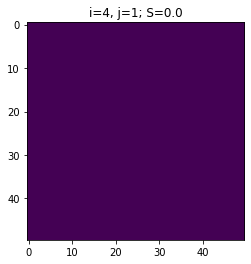

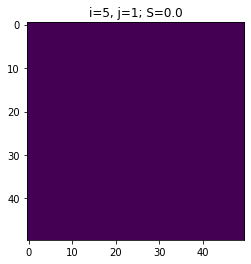

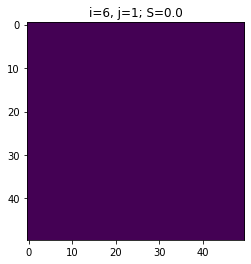

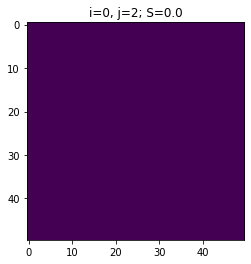

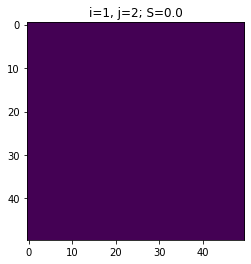

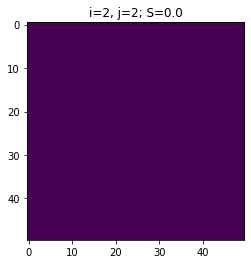

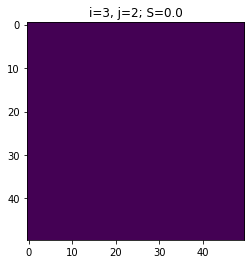

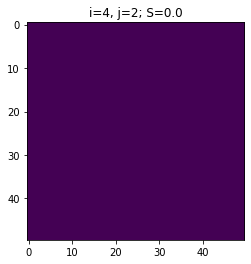

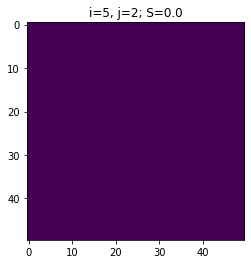

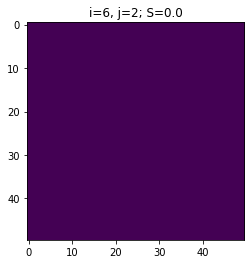

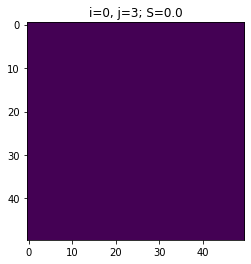

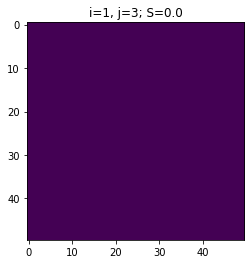

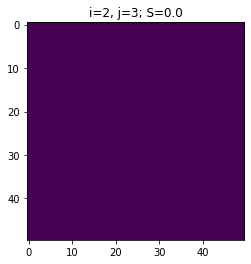

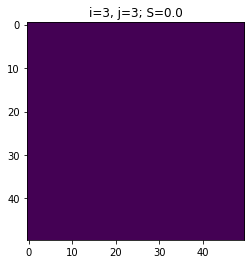

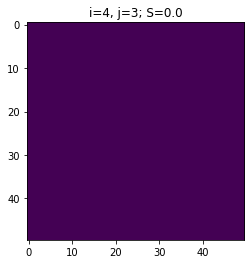

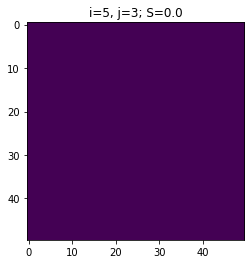

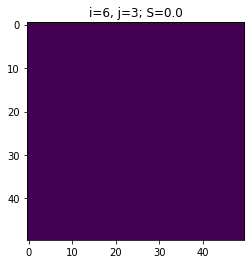

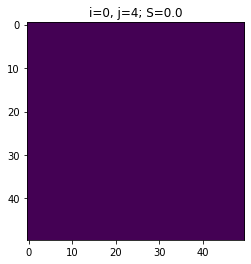

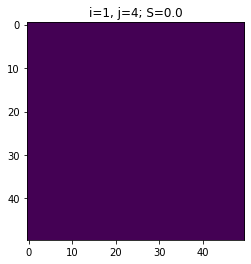

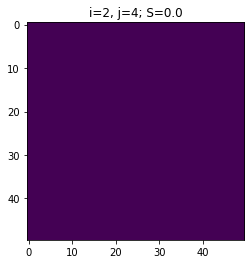

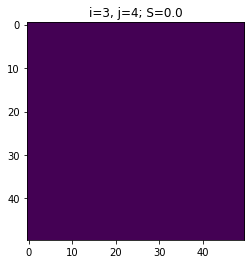

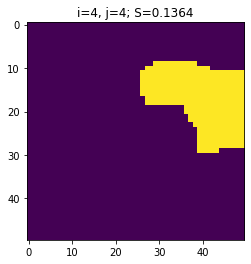

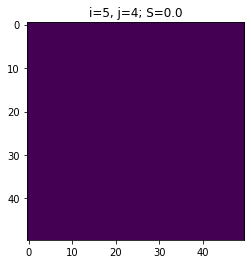

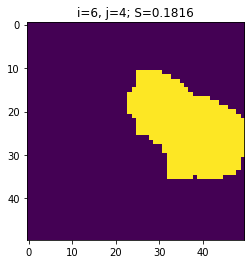

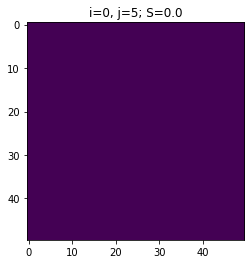

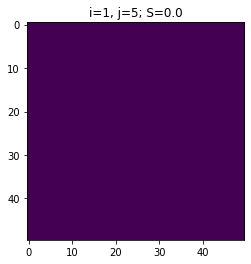

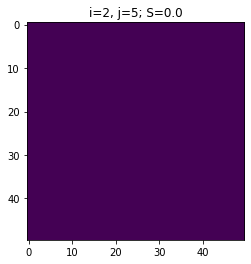

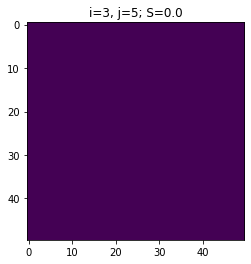

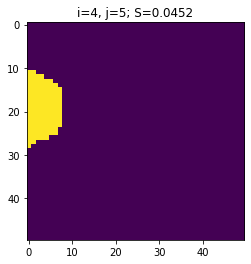

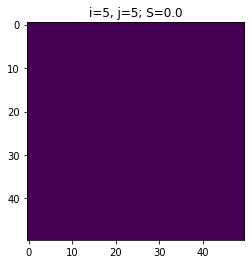

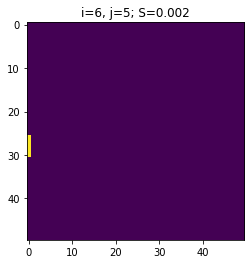

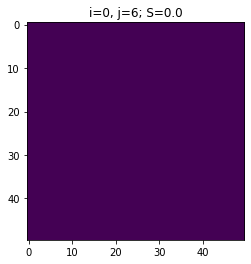

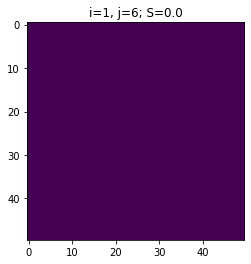

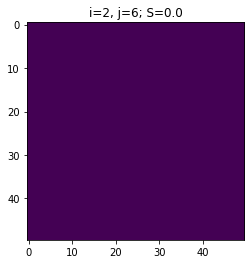

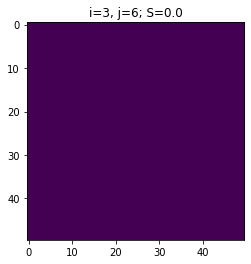

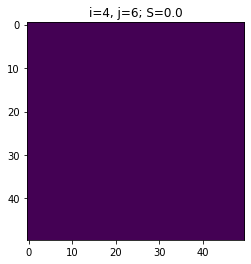

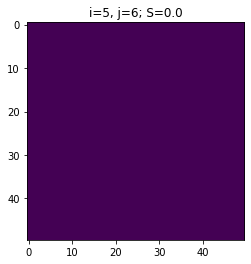

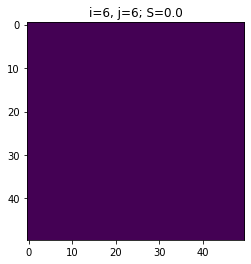

In [92]:
step = 50
i, j = 3, 5
for j in range(7):
    for i in range(7):
        sub_diff = diff_t[step*i: step*(i+1), step*j: step*(j+1)]
        plt.title(f"i={i}, j={j}; S={(sub_diff != 0).sum()/(step*step)}")
        plt.imshow(sub_diff)
        plt.show()

In [53]:
i, j = 6, 3
sub_diff = diff[step*i: step*(i+1), step*j: step*(j+1)]
plt.imshow(sub_diff)

NameError: name 'step' is not defined

In [247]:
sub_diff.max()

56

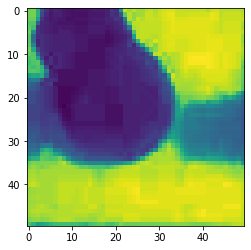

In [194]:
step = int(width / 8)
plt.imshow(frame[:step, :step])

In [195]:
frame.shape

(400, 400)

In [1]:
hand_on_last = False
hand_on_cur = handOn(frame)

hand_on_change = hand_on_cur ^ hand_on_last

if hand_on_change and not hand_on_cur:
    diff = cv2.absdiff(frame, last_frame)

    cur_move = getMove(diff)
    print(cur_move)
    last_frame = frame.copy()
        

hand_on_last = hand_on_cur

NameError: name 'handOn' is not defined

In [197]:
t, grid = getGridSum(frame)

In [199]:
t

1347916

In [202]:
(chess_grid_sum - t) / chess_grid_sum

0.12236767142731574

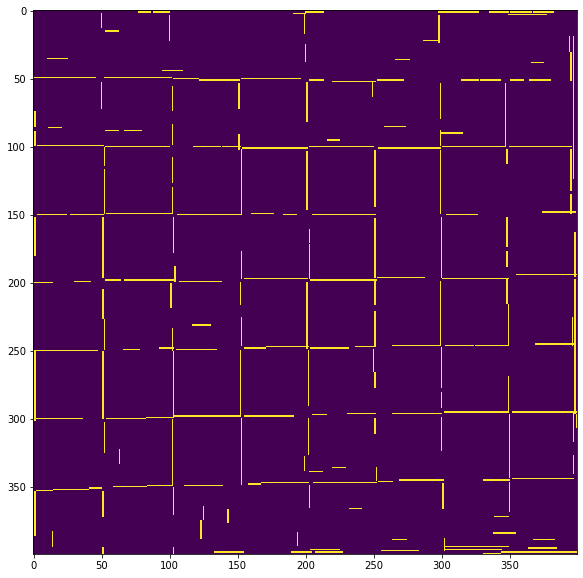

In [198]:
plt.figure(figsize=(10, 10))
plt.imshow(grid)